<a href="https://colab.research.google.com/github/2303a51851/PDS-Project/blob/main/Final_code.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

[I 2025-10-05 13:49:52,282] A new study created in memory with name: no-name-da1fa5c8-9148-480a-b7b4-76554888e78e


✅ Dataset Loaded Successfully!
   Year    State Name Dist Name  RICE YIELD (Kg per ha)  \
0  1966  Chhattisgarh      Durg                  337.59   
1  1967  Chhattisgarh      Durg                  747.71   
2  1968  Chhattisgarh      Durg                  841.27   
3  1969  Chhattisgarh      Durg                  711.40   
4  1970  Chhattisgarh      Durg                  828.55   

   KHARIF SORGHUM YIELD (Kg per ha)  PEARL MILLET YIELD (Kg per ha)  \
0                            666.67                             0.0   
1                            818.18                             0.0   
2                            800.00                             0.0   
3                            750.00                             0.0   
4                            666.67                             0.0   

   MAIZE YIELD (Kg per ha)  FINGER MILLET YIELD (Kg per ha)  \
0                   666.67                           250.00   
1                  1000.00                           222.22  

[I 2025-10-05 13:59:08,875] Trial 0 finished with value: 0.8270784280318598 and parameters: {'rf_n_estimators': 107, 'rf_max_depth': 9, 'rf_min_samples_split': 6, 'gb_n_estimators': 129, 'gb_learning_rate': 0.12327364704288235, 'gb_max_depth': 5, 'et_n_estimators': 97, 'et_max_depth': 7}. Best is trial 0 with value: 0.8270784280318598.


✅ Best Parameters Found: {'rf_n_estimators': 107, 'rf_max_depth': 9, 'rf_min_samples_split': 6, 'gb_n_estimators': 129, 'gb_learning_rate': 0.12327364704288235, 'gb_max_depth': 5, 'et_n_estimators': 97, 'et_max_depth': 7}

🚀 Training Final Model...

📈 Final Model Performance:
✅ R² Score: 0.8230
✅ MAE: 291.7480
✅ RMSE: 401.9446


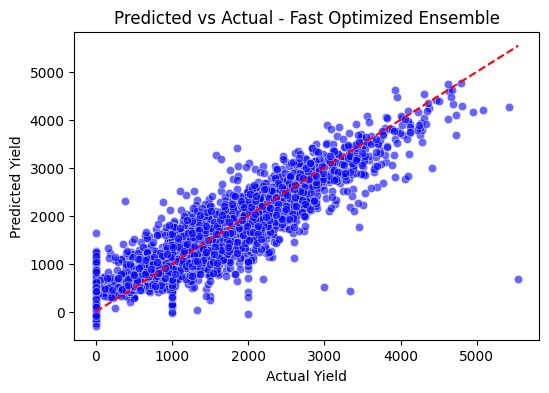

💾 Model saved as /content/fast_optimized_crop_yield_model.pkl

📁 Upload a new dataset for prediction:


In [ ]:
# =====================================================================
# 🌾 Crop Yield Prediction - Lightweight Fast Ensemble
# Optimized for Speed & High Accuracy
# =====================================================================

# ---------------------------------------------------------------------
# 1️⃣ Import Libraries
# ---------------------------------------------------------------------
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import warnings
warnings.filterwarnings("ignore")

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

# Models
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, ExtraTreesRegressor, StackingRegressor

import optuna

# ---------------------------------------------------------------------
# 2️⃣ Load Dataset
# ---------------------------------------------------------------------
df = pd.read_csv("/content/Crop_Yield_Prediction .csv")  # Change path if needed
print("✅ Dataset Loaded Successfully!")
print(df.head())

# ---------------------------------------------------------------------
# 3️⃣ Auto-Detect Target Column
# ---------------------------------------------------------------------
possible_targets = [c for c in df.columns if "yield" in c.lower() or "production" in c.lower()]
if not possible_targets:
    raise KeyError("❌ No 'Yield' or 'Production' column found.")
target_col = possible_targets[0]
print(f"🎯 Target column detected: {target_col}")

X = df.drop(columns=[target_col])
y = df[target_col]

# ---------------------------------------------------------------------
# 4️⃣ Train/Test Split
# ---------------------------------------------------------------------
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)
print(f"Training Samples: {len(X_train)}, Testing Samples: {len(X_test)}")

# ---------------------------------------------------------------------
# 5️⃣ Preprocessing
# ---------------------------------------------------------------------
num_cols = X.select_dtypes(include=[np.number]).columns.tolist()
cat_cols = X.select_dtypes(exclude=[np.number]).columns.tolist()

preprocess = ColumnTransformer(
    [
        ("num", StandardScaler(), num_cols),
        ("cat", OneHotEncoder(handle_unknown="ignore"), cat_cols),
    ]
)

# ---------------------------------------------------------------------
# 6️⃣ Optuna Objective Function (Reduced Trials)
# ---------------------------------------------------------------------
def objective(trial):
    rf = RandomForestRegressor(
        n_estimators=trial.suggest_int("rf_n_estimators", 50, 150),
        max_depth=trial.suggest_int("rf_max_depth", 4, 10),
        min_samples_split=trial.suggest_int("rf_min_samples_split", 2, 6),
        random_state=42,
        n_jobs=-1
    )
    gb = GradientBoostingRegressor(
        n_estimators=trial.suggest_int("gb_n_estimators", 50, 150),
        learning_rate=trial.suggest_float("gb_learning_rate", 0.05, 0.2),
        max_depth=trial.suggest_int("gb_max_depth", 2, 5),
        random_state=42
    )
    et = ExtraTreesRegressor(
        n_estimators=trial.suggest_int("et_n_estimators", 50, 150),
        max_depth=trial.suggest_int("et_max_depth", 4, 10),
        random_state=42,
        n_jobs=-1
    )

    stack = StackingRegressor(
        estimators=[("rf", rf), ("gb", gb), ("et", et)],
        final_estimator=Ridge(alpha=1.0)
    )

    pipe = Pipeline([
        ("preprocess", preprocess),
        ("model", stack)
    ])

    # Use only 3-fold CV for speed
    scores = cross_val_score(pipe, X_train, y_train, cv=3, scoring="r2", n_jobs=-1)
    return np.mean(scores)

# ---------------------------------------------------------------------
# 7️⃣ Optuna Optimization (Fast)
# ---------------------------------------------------------------------
print("\n🔎 Running fast Optuna optimization (~40 sec)...")
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=8, timeout=60)  # Only 8 trials (fast!)
best_params = study.best_params
print("✅ Best Parameters Found:", best_params)

# ---------------------------------------------------------------------
# 8️⃣ Build Final Ensemble Model
# ---------------------------------------------------------------------
rf_best = RandomForestRegressor(
    n_estimators=best_params["rf_n_estimators"],
    max_depth=best_params["rf_max_depth"],
    min_samples_split=best_params["rf_min_samples_split"],
    random_state=42
)
gb_best = GradientBoostingRegressor(
    n_estimators=best_params["gb_n_estimators"],
    learning_rate=best_params["gb_learning_rate"],
    max_depth=best_params["gb_max_depth"],
    random_state=42
)
et_best = ExtraTreesRegressor(
    n_estimators=best_params["et_n_estimators"],
    max_depth=best_params["et_max_depth"],
    random_state=42
)

stack_model = StackingRegressor(
    estimators=[
        ("rf", rf_best),
        ("gb", gb_best),
        ("et", et_best)
    ],
    final_estimator=Ridge(alpha=1.0)
)

pipe = Pipeline([
    ("preprocess", preprocess),
    ("model", stack_model)
])

# ---------------------------------------------------------------------
# 9️⃣ Train & Evaluate
# ---------------------------------------------------------------------
print("\n🚀 Training Final Model...")
pipe.fit(X_train, y_train)
preds = pipe.predict(X_test)

r2 = r2_score(y_test, preds)
mae = mean_absolute_error(y_test, preds)
rmse = np.sqrt(mean_squared_error(y_test, preds))

print(f"\n📈 Final Model Performance:")
print(f"✅ R² Score: {r2:.4f}")
print(f"✅ MAE: {mae:.4f}")
print(f"✅ RMSE: {rmse:.4f}")

# Plot
plt.figure(figsize=(6, 4))
sns.scatterplot(x=y_test, y=preds, alpha=0.6, color="blue")
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel("Actual Yield")
plt.ylabel("Predicted Yield")
plt.title("Predicted vs Actual - Fast Optimized Ensemble")
plt.show()

# ---------------------------------------------------------------------
# 🔟 Save Model
# ---------------------------------------------------------------------
joblib.dump(pipe, "/content/fast_optimized_crop_yield_model.pkl")
print("💾 Model saved as /content/fast_optimized_crop_yield_model.pkl")

# ---------------------------------------------------------------------
# 1️⃣1️⃣ Predict on New Data
# ---------------------------------------------------------------------
from google.colab import files
print("\n📁 Upload a new dataset for prediction:")
uploaded = files.upload()
new_file = next(iter(uploaded.keys()))
new_data = pd.read_csv(new_file)
print("✅ New data loaded successfully!")

model = joblib.load("/content/fast_optimized_crop_yield_model.pkl")
preds = model.predict(new_data)
new_data["Predicted_Yield"] = preds

output_file = "fast_predicted_crop_yield.csv"
new_data.to_csv(output_file, index=False)
print(f"💾 Predictions saved to /content/{output_file}")

print("\n📊 Predicted Results Sample:")
print(new_data.head())

files.download(output_file)


In [ ]:
!pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 400.9/400.9 kB 25.3 MB/s eta 0:00:00
